In [1]:
# are the future functions actually necessary?
from __future__ import absolute_import, division, print_function, unicode_literals
import imp

from data_read import read_paths
from pathData import PathData
from snapData import SnapData
from datasetData import DatasetData
from plotData import PlotData
from importanceData import ImportanceData
#from data_plot import map_generated

import numpy as np
import tensorflow as tf
from tensorflow import keras

np.set_printoptions(precision=3, suppress=True)
# allows for automatic reloading of imports and makes it unncessecary to restart the kernel
# whenever a functio is changed
%load_ext autoreload
%autoreload 2

In [2]:
ALL_VAR_NAMES = {
    0: "MCG",
    1: "N_{w,4}",
    2: "N_{w,3}",
    3: "N_{w,2}",
    4: "N_{sw,3-4}",
    5: "N_{sw,2-3}",
    6: "F4",
    7: "R_g",
    8: "5^{12}6^{2}",
    9: "5^{12}",
    10: "CR",
    11: "N_{s,2}",
    12:"N_{s,3}",
    13: "N_{c,2}",
    14: "N_{c,3}",
    15: "N_{s,4}",
    16: "N_{c,4}",
    17: "5^{12}6^{3}",
    18: "5^{12}6^{4}",
    19: "4^{1}5^{10}6^{2}",
    20: "4^{1}5^{10}6^{3}",
    21: "4^{1}5^{10}6^{4}"
}
ALL_VAR_ORDER = [
    0, 11, 12,15, 13, 14, 16, 3,
    2, 1, 5, 4, 9, 8, 17, 18, 
    19, 20, 21, 10, 7, 6
    ]

# Set the variables to be used.
USED_VARS = sorted([0, 6, 7, 8, 9, 10, 11, 13, 3])

# Use disctionary comprehension generate a new dictionary
# containing the names of the variables used.
VAR_NAMES = {i:ALL_VAR_NAMES[USED_VARS[i]] for i in range(len(USED_VARS))}
print(VAR_NAMES)


# Generate a new list containing the variable order for only the used variables.
VAR_ORDER = [USED_VARS.index(i) for i in ALL_VAR_ORDER if i in USED_VARS]
print(VAR_ORDER)

{0: 'MCG', 1: 'N_{w,2}', 2: 'F4', 3: 'R_g', 4: '5^{12}6^{2}', 5: '5^{12}', 6: 'CR', 7: 'N_{s,2}', 8: 'N_{c,2}'}
[0, 7, 8, 1, 5, 4, 6, 3, 2]


In [30]:
"""Per-Dataset parameters"""
# name of the parent folder in which the complete data is found
FOLDER_NAME = "RPE"
# MCG threshold below which a snapshot is considered to belong to state A
MCG_A = 18
# MCG threshold above which a snapshot is considered to belong to state B
MCG_B = 120
# labels assigend to the four types of paths: AA, AB, BA, BB
PATH_TYPE_LABELS = [-1.0, 0.0, 0.0, 1.0]
# weights assigned to the totatlity of each of the path types. Will be normalized on sum of all four weights
PATH_TYPE_WEIGHTS = [1, 10, 0, 0]
# offset to generate datasets with future predictions
OFFSET = 0
# if True snapshots of transition paths are assigned labels according to their position within the path 
PROGRESS = True
# if True transition paths (AB, BA) are taken into account for the dataset
TRANSITIONED = True
# if True paths returning to their starting state (AA, BB) are taken into acount for the dataset
TURNEDBACK = True
# ratio of training set compared to the whole dataset
TRAIN_RATIO = 0.6
# ratio of validation set compared to whole dataset
VAL_RATIO = 0.1
# fraction of most extreme values that are considered outliers to both sides
OUTLIER_CUTOFF = 0.05
#print("Assuming an independent distribution of the dimensions, {:.3f}% of the dataset \
#will be considered to contain outliers.".format(100*(1-(1-2*OUTLIER_CUTOFF)**DIMENSIONS)))

In [31]:
"""System parameters"""
# number of cores used
CORES_USED = 2

In [32]:
"""Tf-Dataset parameters"""
# set size of batches
BATCH_SIZE = 64
# determines whether the last n values are going to be dropped if no complete batch can be build from them
#DROP_REMAINDER = False


In [33]:
"""Model parameters"""
# number of bottleneck nodes
BOTTLENECK_SIZE = 2
# weight of the label loss and reconstruction loss. Only the relative ratio is relevant
LABEL_LOSS_WEIGHT = 1
RECONSTRUCTION_LOSS_WEIGHT = 1
# names of input and output in the model
INPUT_NAME = "input_snapshots"
OUTPUT_NAME_1 = "label"
OUTPUT_NAME_2 = "reconstruction"
# list off losses determined by the model. Utilized by the plot_all_input_importance function
LOSS_NAMES = ["total", OUTPUT_NAME_1, OUTPUT_NAME_2]
LOSS_TYPE_COUNT = len(LOSS_NAMES)
# number of epochs used for model training
EPOCHS = 2

In [34]:
"""Visialization parameters"""
# resolution for the plotting functions
RESOLUTION = 25
# figure size for the plotting functions function
SUBFIG_SIZE = 5

In [35]:
"""Input importance parameters"""
# sets thresholds for the strengt of correlation needed to be considered "correlated"
WEAK_CORRELATION_TRESHOLD = 0.01
STRONG_CORRELATION_TRESHOLD = 0.1

In [36]:
pathO = PathData(
    *read_paths(
        FOLDER_NAME, 
        MCG_A, 
        MCG_B,
        USED_VARS), 
    PATH_TYPE_LABELS, 
    PATH_TYPE_WEIGHTS)

mcg100
mcg30


In [37]:
snapO = SnapData(
    *pathO.snapshots_labels_weights(
        offset = OFFSET, 
        progress = PROGRESS, 
        transitioned = TRANSITIONED, 
        turnedback = TURNEDBACK))

1082141.0 114988.0
108829.90909271047 1088299.0909108156


In [38]:
dataO = DatasetData(
    *snapO.split_lists(TRAIN_RATIO, VAL_RATIO), 
    outlier_cutoff = OUTLIER_CUTOFF)

In [39]:
#print(dataO.mean)
#print(dataO.std)
#print(dataO.minima)
#print(dataO.maxima)

In [40]:
# generates the dataset by feeding in a tuple, of dictionaries (alternative would be a tuble of lists)
train_ds = tf.data.Dataset.from_tensor_slices(
    ({INPUT_NAME: dataO.train_norm_past_snapshots}, 
    {OUTPUT_NAME_1: dataO.train_snapshot_labels, 
    OUTPUT_NAME_2: dataO.train_norm_snapshots}, 
    {OUTPUT_NAME_1: dataO.train_snapshot_weights, 
    OUTPUT_NAME_2: dataO.train_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(BATCH_SIZE)
print("train_ds generated")
val_ds = tf.data.Dataset.from_tensor_slices(
    ({INPUT_NAME: dataO.val_norm_past_snapshots}, 
    {OUTPUT_NAME_1: dataO.val_snapshot_labels, 
    OUTPUT_NAME_2: dataO.val_norm_snapshots}, 
    {OUTPUT_NAME_1: dataO.val_snapshot_weights, 
    OUTPUT_NAME_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(BATCH_SIZE)
print("val_ds generated")


train_ds generated
val_ds generated


In [41]:
NODE_MULT = 4
ENCODER_HIDDEN = 4
DECODER_1_HIDDEN = 4
DECODER_2_HIDDEN = 4
ENCODER_ACT_FUNC = None
DECODER_1_ACT_FUNC = "tanh"
DECODER_2_ACT_FUNC = "tanh"
encoder_input = keras.Input(shape=(dataO.dimensions,),name=INPUT_NAME)
x = keras.layers.Dense(dataO.dimensions*NODE_MULT, activation= ENCODER_ACT_FUNC)(encoder_input)
for i in range(ENCODER_HIDDEN - 1):
    x = keras.layers.Dense(dataO.dimensions*NODE_MULT, activation=ENCODER_ACT_FUNC)(x)
#x = keras.layers.Dropout(0.1)(x)
#x = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x)
#x = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x)

encoder_output = keras.layers.Dense(BOTTLENECK_SIZE, activation=ENCODER_ACT_FUNC, name='bottleneck')(x)

encoder = keras.Model(encoder_input, encoder_output, name ="Encoder")
#encoder.summary()

decoder_input = keras.Input(shape=(BOTTLENECK_SIZE,), name ="encoded_snapshots")

x1 = keras.layers.Dense(dataO.dimensions*NODE_MULT, activation=DECODER_1_ACT_FUNC)(decoder_input)
for i in range(DECODER_1_HIDDEN):
    x1 = keras.layers.Dense(dataO.dimensions*NODE_MULT, activation=DECODER_1_ACT_FUNC)(x1)
#x1 = keras.layers.Dropout(0.1)(x1)
#x1 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x1)
#x1 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x1)
decoder_output_1 = keras.layers.Dense(1, activation=DECODER_1_ACT_FUNC, name=OUTPUT_NAME_1)(x1)
decoder_1 = keras.Model(decoder_input, decoder_output_1, name = OUTPUT_NAME_1)
#decoder_1.summary()

x2 = keras.layers.Dense(dataO.dimensions*NODE_MULT, activation=DECODER_2_ACT_FUNC)(decoder_input)
for i in range(DECODER_2_HIDDEN):
    x2 = keras.layers.Dense(dataO.dimensions*NODE_MULT, activation=DECODER_2_ACT_FUNC)(x2)
#x2 = keras.layers.Dropout(0.1)(x2)
#x2 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x2)
#x2 = keras.layers.Dense(DIMENSIONS*NODE_MULT, activation='tanh')(x2)
decoder_output_2 = keras.layers.Dense(dataO.dimensions, activation=DECODER_2_ACT_FUNC,name=OUTPUT_NAME_2)(x2)
decoder_2 = keras.Model(decoder_input, decoder_output_2, name = OUTPUT_NAME_2)
#decoder_2.summary()

autoencoder_input = keras.Input(shape=(dataO.dimensions,), name=INPUT_NAME)
encoded_snaphot = encoder(autoencoder_input)
label_snapshot = decoder_1(encoded_snaphot)
reconstructed_snapshot = decoder_2(encoded_snaphot)
autoencoder = keras.Model(inputs=autoencoder_input, \
                          outputs=[label_snapshot,reconstructed_snapshot], \
                          name = "Autoencoder")

#model_layout = keras.utils.plot_model(autoencoder, 'autoencoder.png', show_shapes=True)
#display.display(model_layout)

#display.display(keras.utils.plot_model(encoder, 'encoder.png', show_shapes=True))
#display.display(keras.utils.plot_model(decoder_1, 'decoder_1.png', show_shapes=True))
#display.display(keras.utils.plot_model(decoder_2, 'decoder_2.png', show_shapes=True))

In [42]:
autoencoder.compile(optimizer=keras.optimizers.RMSprop(1e-3),
#                loss={OUTPUT_NAME_1:keras.losses.CategoricalHinge(),
                loss={OUTPUT_NAME_1:keras.losses.MeanSquaredError(),
                     OUTPUT_NAME_2: keras.losses.MeanAbsoluteError()},
                loss_weights=[LABEL_LOSS_WEIGHT, RECONSTRUCTION_LOSS_WEIGHT])

autoencoder_1 = keras.Model(inputs=autoencoder_input, outputs=label_snapshot, name = "Autoencoder_1")
autoencoder_1.compile(optimizer=keras.optimizers.RMSprop(1e-3), \
#                loss={OUTPUT_NAME_1:keras.losses.CategoricalHinge()}, \
                loss={OUTPUT_NAME_1:keras.losses.MeanSquaredError()},
                loss_weights=[LABEL_LOSS_WEIGHT])

autoencoder_2 = keras.Model(inputs=autoencoder_input, outputs=reconstructed_snapshot, name = "Autoencoder_2")
autoencoder_2.compile(optimizer=keras.optimizers.RMSprop(1e-3), \
                loss={OUTPUT_NAME_2:keras.losses.MeanSquaredError()}, \
                loss_weights=[RECONSTRUCTION_LOSS_WEIGHT])

In [43]:
#autoencoder.fit(train_ds_batch,epochs=EPOCHS, class_weight=class_weight)

history = autoencoder.fit(train_ds,epochs=EPOCHS, validation_data=val_ds)

Train for 11224 steps, validate for 1871 steps
Epoch 1/2
11224/11224 [==============================] - 34s 3ms/step - loss: 0.6600 - label_loss: 0.0795 - reconstruction_loss: 0.5805 - val_loss: 0.6800 - val_label_loss: 0.1016 - val_reconstruction_loss: 0.5784
Epoch 2/2
11224/11224 [==============================] - 35s 3ms/step - loss: 0.6306 - label_loss: 0.0704 - reconstruction_loss: 0.5602 - val_loss: 0.6237 - val_label_loss: 0.0745 - val_reconstruction_loss: 0.5492


In [44]:
STAMP = "tr{}_re{}_p{}_o{}_oc{}_bn{}_{}*({}{}+{}{}|{}{})_pw{}:{}:{}:{}_lw{}:{}_e{}" \
    .format(str(TRANSITIONED)[0],str(TURNEDBACK)[0], 
        str(PROGRESS)[0], OFFSET, OUTLIER_CUTOFF,
        str(BOTTLENECK_SIZE), str(NODE_MULT), 
        str(ENCODER_HIDDEN), str(ENCODER_ACT_FUNC), 
        str(DECODER_1_HIDDEN), str(DECODER_1_ACT_FUNC), 
        str(DECODER_2_HIDDEN), str(DECODER_2_ACT_FUNC), 
        PATH_TYPE_WEIGHTS[0],PATH_TYPE_WEIGHTS[1], 
        PATH_TYPE_WEIGHTS[2],PATH_TYPE_WEIGHTS[3], 
        LABEL_LOSS_WEIGHT, RECONSTRUCTION_LOSS_WEIGHT, 
        EPOCHS)

In [45]:
plotO = PlotData(*dataO.plot_data(), STAMP)

1: N_{s,2}	0: MCG
2: N_{c,2}	0: MCG
2: N_{c,2}	1: N_{s,2}
3: N_{w,2}	0: MCG
3: N_{w,2}	1: N_{s,2}
3: N_{w,2}	2: N_{c,2}
4: 5^{12}	0: MCG
4: 5^{12}	1: N_{s,2}
4: 5^{12}	2: N_{c,2}
4: 5^{12}	3: N_{w,2}
5: 5^{12}6^{2}	0: MCG
5: 5^{12}6^{2}	1: N_{s,2}
5: 5^{12}6^{2}	2: N_{c,2}
5: 5^{12}6^{2}	3: N_{w,2}
5: 5^{12}6^{2}	4: 5^{12}
6: CR	0: MCG
6: CR	1: N_{s,2}
6: CR	2: N_{c,2}
6: CR	3: N_{w,2}
6: CR	4: 5^{12}
6: CR	5: 5^{12}6^{2}
7: R_g	0: MCG
7: R_g	1: N_{s,2}
7: R_g	2: N_{c,2}
7: R_g	3: N_{w,2}
7: R_g	4: 5^{12}
7: R_g	5: 5^{12}6^{2}
7: R_g	6: CR
8: F4	0: MCG
8: F4	1: N_{s,2}
8: F4	2: N_{c,2}
8: F4	3: N_{w,2}
8: F4	4: 5^{12}
8: F4	5: 5^{12}6^{2}
8: F4	6: CR
8: F4	7: R_g
0


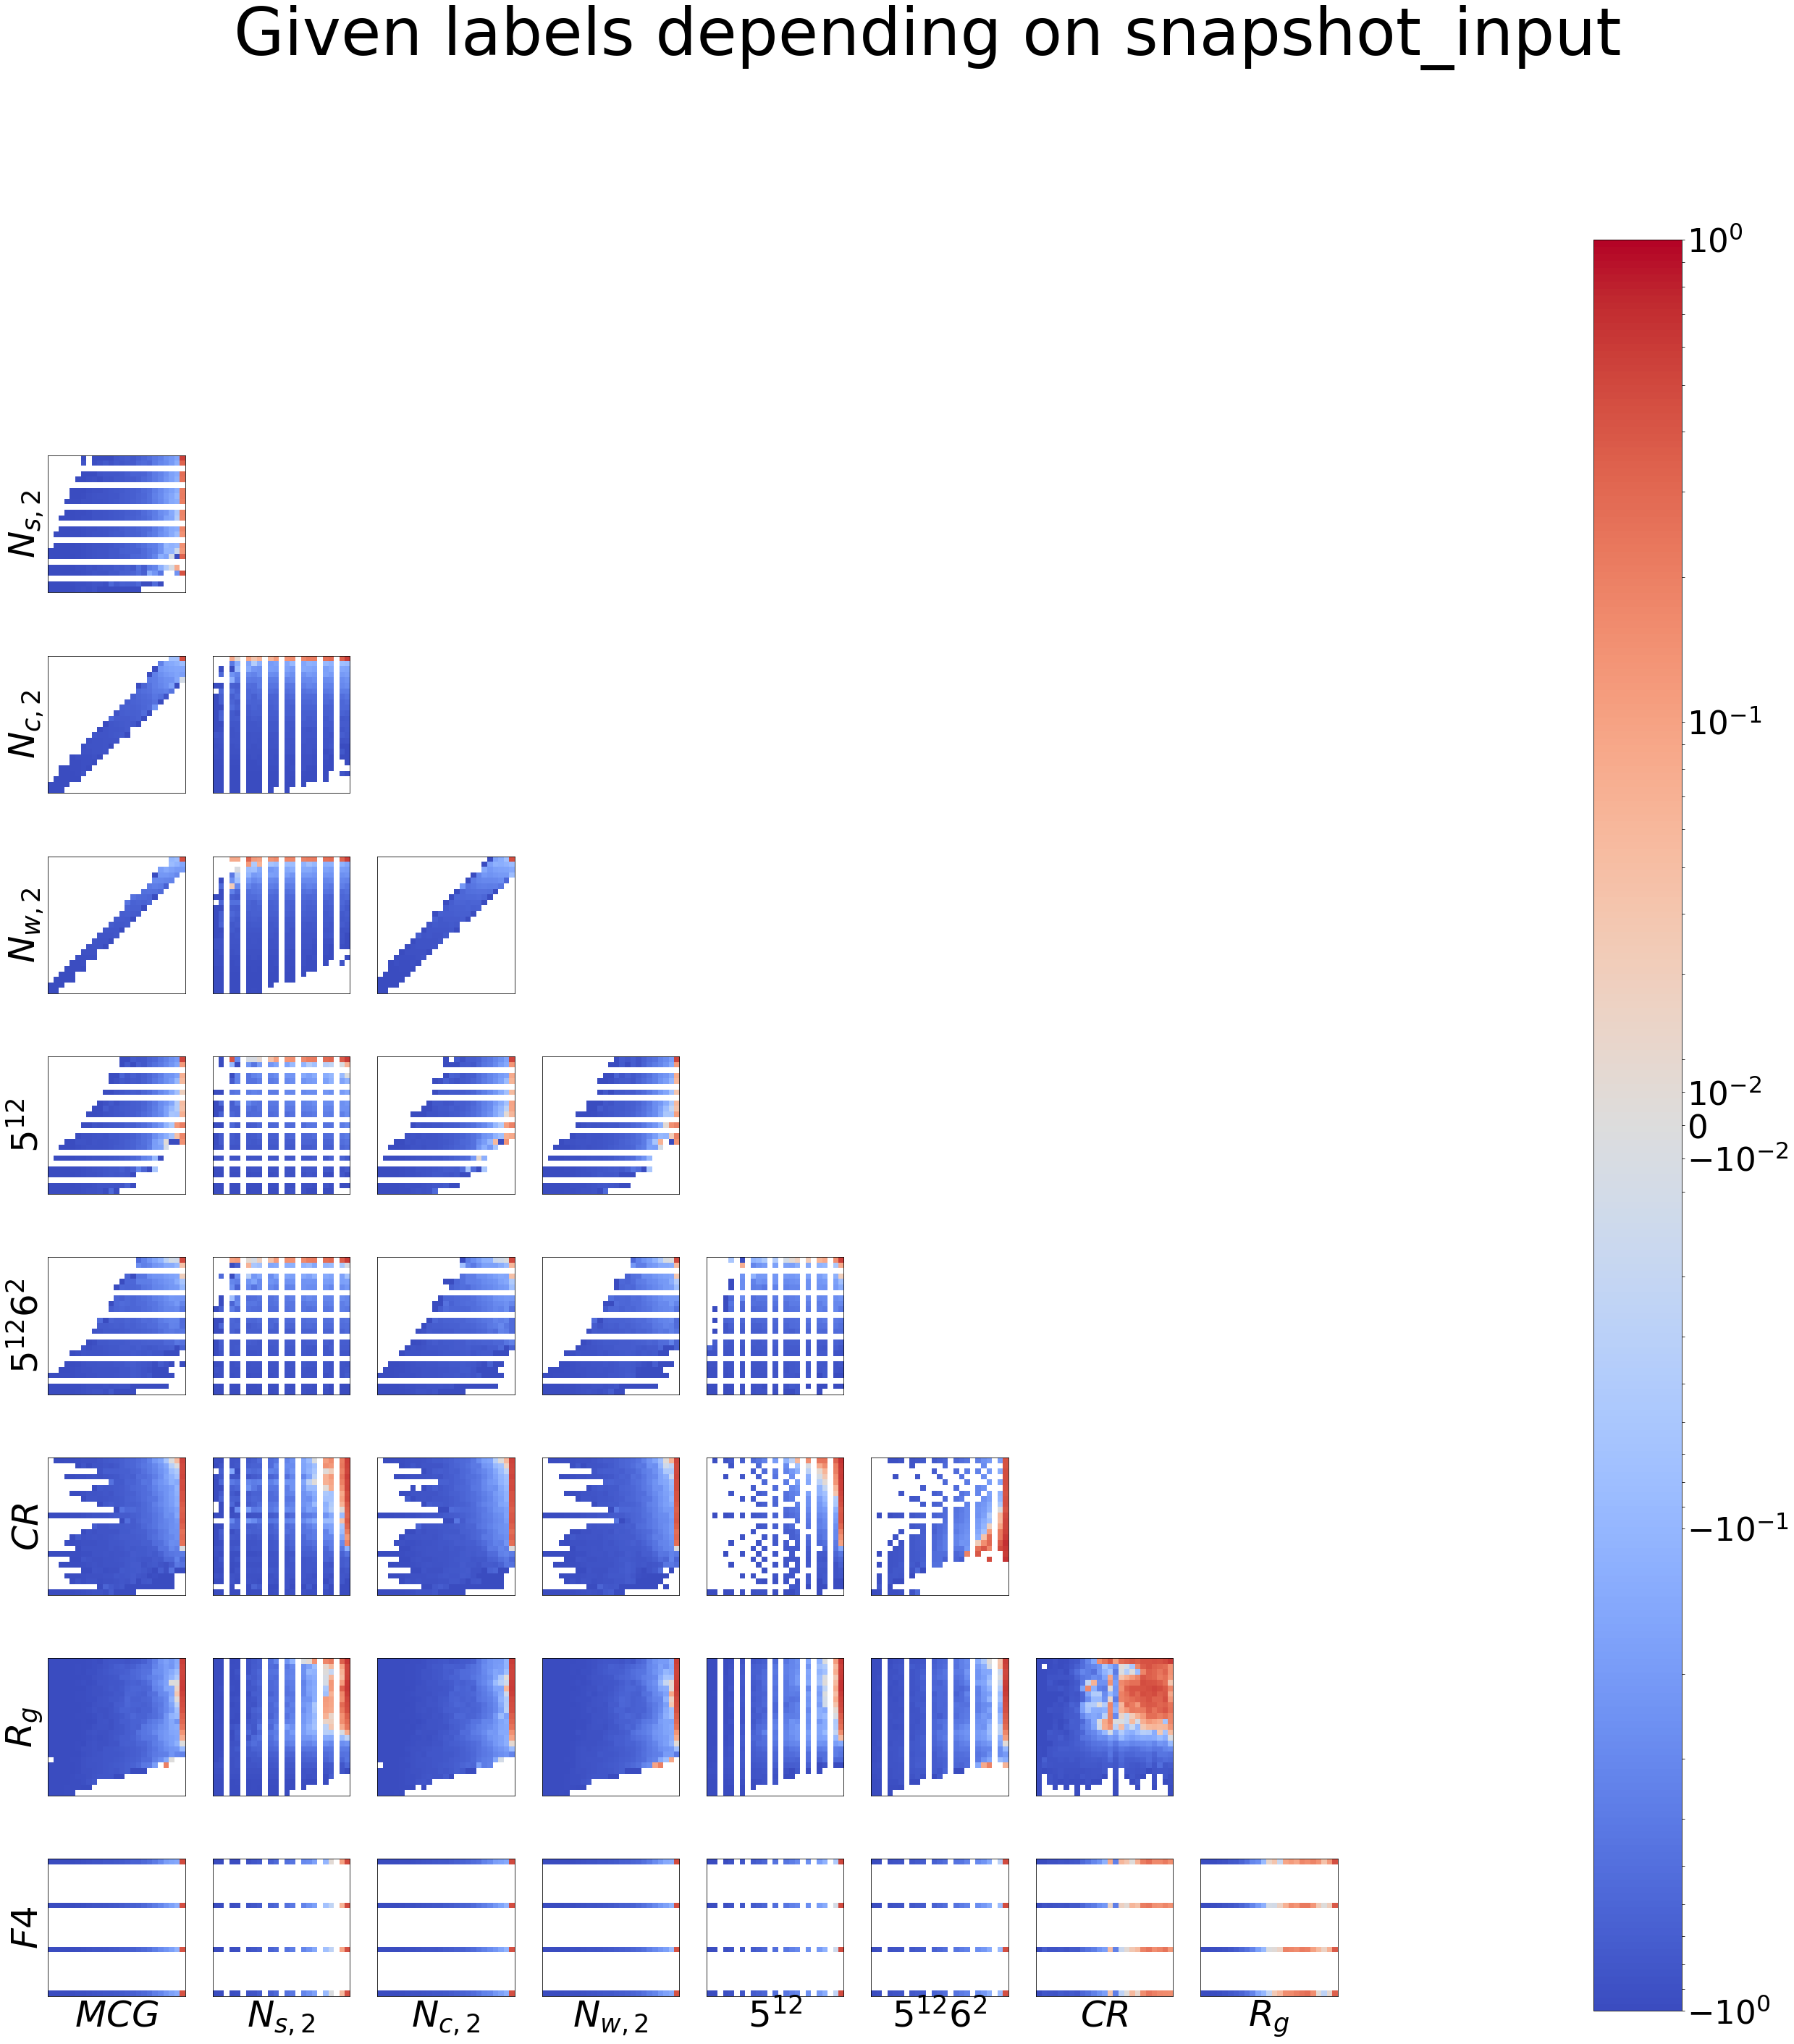

In [46]:

plotO.plot_super_map(subfig_size = SUBFIG_SIZE, i_s = VAR_ORDER, js = VAR_ORDER, \
                     stamp = STAMP, var_names = VAR_NAMES, resolution = RESOLUTION, \
                     vmin = -1.0, vmax = 1.0, \
                     model = None, fill_val = 0)
        

pass

In [ ]:
plotO.plot_super_map(subfig_size = SUBFIG_SIZE, i_s = VAR_ORDER, js = VAR_ORDER, \
                     stamp = STAMP, var_names = VAR_NAMES, resolution = RESOLUTION, \
                     vmin = -1.0, vmax = 1.0, \
                     model = autoencoder_1, fill_val = 0)
pass

1: N_{s,2}	0: MCG
2: N_{c,2}	0: MCG
2: N_{c,2}	1: N_{s,2}
3: N_{w,2}	0: MCG
3: N_{w,2}	1: N_{s,2}
3: N_{w,2}	2: N_{c,2}
4: 5^{12}	0: MCG
4: 5^{12}	1: N_{s,2}
4: 5^{12}	2: N_{c,2}
4: 5^{12}	3: N_{w,2}
5: 5^{12}6^{2}	0: MCG
5: 5^{12}6^{2}	1: N_{s,2}
5: 5^{12}6^{2}	2: N_{c,2}
5: 5^{12}6^{2}	3: N_{w,2}


In [ ]:
plotO.plot_super_scatter(subfig_size = SUBFIG_SIZE, i_s = VAR_ORDER, \
                         stamp = STAMP, var_names = VAR_NAMES, resolution = RESOLUTION, \
                         model = autoencoder_2, max_row_len = 6, fill_val = 0)

In [ ]:
impO = ImportanceData(
    *dataO.importance_data(),
    WEAK_CORRELATION_TRESHOLD,
    STRONG_CORRELATION_TRESHOLD)

impO.measure_correlation()
pass

In [ ]:
val_ds = tf.data.Dataset.from_tensor_slices(
    ({INPUT_NAME: dataO.val_norm_past_snapshots}, 
    {OUTPUT_NAME_1: dataO.val_snapshot_labels, 
    OUTPUT_NAME_2: dataO.val_norm_snapshots}, 
    {OUTPUT_NAME_1: dataO.val_snapshot_weights, 
    OUTPUT_NAME_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(BATCH_SIZE)
print("val_ds generated")

modes = [["Mean", None],["HIPR", [-0.9,0.9]],["Shuffle", None]]
#modes = [["Perturb", 0.5]]

impO.plot_super_importance(
    subfig_size = SUBFIG_SIZE, i_s = VAR_ORDER, stamp = STAMP,
    var_names = VAR_NAMES, repetitions = 1, modes = modes,
    loss_names = ["total",OUTPUT_NAME_1, OUTPUT_NAME_2],
    val_ds = val_ds, model = autoencoder)


In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices(
    ({INPUT_NAME: dataO.test_norm_past_snapshots}, 
    {OUTPUT_NAME_1: dataO.test_snapshot_labels, 
    OUTPUT_NAME_2: dataO.test_norm_snapshots}, 
    {OUTPUT_NAME_1: dataO.test_snapshot_weights, 
    OUTPUT_NAME_2: dataO.test_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(BATCH_SIZE)
print("test_ds generated")

In [ ]:
#VAR_NAMES = {i:ALL_VAR_NAMES[i] for i in USED_VARS}
#VAR_ORDER = [i for i in ALL_VAR_ORDER if i in USED_VARS]
#VAR_ORDER = [i for i in range(len(ALL_VAR_ORDER)) if ALL_VAR_ORDER[i] in USED_VARS]


In [ ]:
"""
VAR_NAMES = {
    0: "MCG",
    11: "N_{s,2}",
    12:"N_{s,3}",    
    15: "N_{s,4}",
    13: "N_{c,2}",
    14: "N_{c,3}",
    16: "N_{c,4}",
    3: "N_{w,2}",   
    2: "N_{w,3}",
    1: "N_{w,4}",
    5: "N_{sw,2-3}",    
    4: "N_{sw,3-4}",
    9: "5^{12}",
    8: "5^{12}6^{2}",
    17: "5^{12}6^{3}",
    18: "5^{12}6^{4}",
    19: "4^{1}5^{10}6^{2}",
    20: "4^{1}5^{10}6^{3}",
    21: "4^{1}5^{10}6^{4}",
    10: "CR",
    7: "R_g",
    6: "F4"
    }"""

"""
VAR_NAMES = {
    0: "MCG"
    1: "N_{s,2}"
    2 :"N_{s,3}"
    3: "N_{s,4}"
    4: "N_{c,2}"
    5: "N_{c,3}"
    6: "N_{c,4}"
    7: "N_{w,2}"
    8: "N_{w,3}"
    9: "N_{w,4}"
    10: "N_{sw,2-3}"
    11: "N_{sw,3-4}"
    12: "5^{12}"
    13: "5^{12}6^{2}"
    14: "5^{12}6^{3}"
    15: "5^{12}6^{4}"
    16: "4^{1}5^{10}6^{2}"
    17: "4^{1}5^{10}6^{3}"
    18: "4^{1}5^{10}6^{4}"
    19: "CR"
    20: "R_g"
    21: "F4"
    }"""
pass

In [17]:
model = autoencoder
print(model.name)
print(model.input_names)
print(model.output_names)

Autoencoder
['input_snapshots']
['label', 'reconstruction']


In [11]:
def show_batch(dataset):
    for batch, label, weights in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))

In [ ]:
#past, present = data.offset_path_lists(5)
#print(past[0][:10])
#print(present[0][:5])
#print(data.path_list[0])
#print(data.label_list[2])
#print(data.mc_weight_list[2])
#AA_past_snapshot_list, AB_past_snapshot_list, \
#    BA_past_snapshot_list, BB_past_snapshot_list, \
#    AA_snapshot_list, AB_snapshot_list, \
#    BA_snapshot_list, BB_snapshot_list, \
#    AA_snapshot_label_list, AB_snapshot_label_list, \
#    BA_snapshot_label_list, BB_snapshot_label_list, \
#    AA_snapshot_weight_list, AB_snapshot_weight_list, \
#    BA_snapshot_weight_list, BB_snapshot_weight_list = paths.snapshot_label_weight_lists(0,True,True,True)